# Imports

In [1]:
import datetime
import os
import sys
from dataclasses import dataclass
import sklearn
from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

2021-08-02 15:21:17.398536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-02 15:21:17.398553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Set the current working directory and get paths of load profiles

In [2]:

cwd = os.getcwd()

In [3]:
def get_directories(path) -> list:
    """
    Returns a list of directories in the given path.
    """
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
directories = get_directories('Profiles')
directories.sort()

# Builds load profile dataframe using all Excel Files

In [4]:
def load_profile_df(filename) -> pd.DataFrame:
    """
    Converts xls and xlsx files to pandas dataframe.
    """
    print(filename)
    f = cwd+'/Profiles/'+filename+'/'+os.listdir(cwd+'/Profiles/'+filename)[0]
    print(f)
    if f.endswith('.xls') or f.endswith('.xlsx'):
        df = pd.read_excel(f, sheet_name=None)
        df = pd.concat(df)
        #print(df)
        df.drop("ADDTIME", axis=1, inplace=True)
        df.rename(columns={"PType_WZ":"Station"}, inplace=True)
        df.drop((df.columns)[-4:], axis=1, inplace=True)
        original_columns = list(df.columns)
        #print(original_columns)
        original_columns[0] = "Station"
        original_columns = ["Load at Interval {}".format(i) for i in range(1, len(original_columns[:])-1)]
        interval_column_labels = original_columns
        
        original_columns.insert(0, "Station")
        original_columns.insert(1, "Date")
        #df['Load Intervals'] = df[interval_column_labels].shift(len(interval_column_labels)-1, axis = "columns")
        #df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
        #print(original_columns)
        df.columns = original_columns
        #print(df.columns)
        #df.groupby(df.index.day).mean()
        #df.set_index('Date', inplace=True)
        #df.set_index(interval_column_labels, inplace=True)
        print(df.head())
    else:
        print('File type not supported. ', f)
        sys.exit()
    return df, interval_column_labels
def concat_all_excel_dfs(directories):
    full_df = pd.DataFrame()
    for d in directories:
        df, _ = load_profile_df(d)
        full_df = pd.concat([full_df, df], ignore_index = True)
    return full_df
my_load_profiles = concat_all_excel_dfs(directories)


ERCOT_Backcasted_Load_Profiles_2016
/home/austin/Desktop/Repositories/dae/Profiles/ERCOT_Backcasted_Load_Profiles_2016/ERCOT Backcasted Load Profiles 2016.xls


ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

# Plots a single day and also prints first 5 rows, shape, columns, and index of the load profile dataframe

MY LOAD DATAFRAME: 
         Station       Date  Load at Interval 1  Load at Interval 2  \
0  BUSHIDG_COAST 2016-01-01              11.489              11.413   
1  BUSHIDG_COAST 2016-01-02              11.668              11.589   
2  BUSHIDG_COAST 2016-01-03              11.457              11.381   
3  BUSHIDG_COAST 2016-01-04              11.358              11.280   
4  BUSHIDG_COAST 2016-01-05              11.492              11.418   

   Load at Interval 3  Load at Interval 4  Load at Interval 5  \
0              11.364              11.325              11.312   
1              11.538              11.494              11.472   
2              11.332              11.291              11.271   
3              11.228              11.182              11.162   
4              11.373              11.338              11.336   

   Load at Interval 6  Load at Interval 7  Load at Interval 8  ...  \
0              11.307              11.273              11.273  ...   
1              11.464 

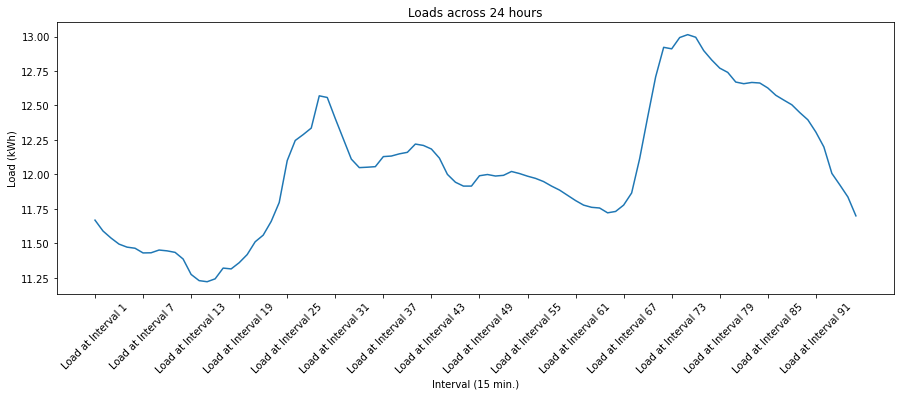

In [ ]:
'''Plot/Evaluate Data'''
def plot_load_data(df):
    """
    Plot the load data for each row in the dataframe."""
    df.drop(df.columns[:2], axis=1, inplace=True)
    #print(df.head())
    plt.figure(figsize=(15,5))
    plt.plot(df.iloc[1, :])
    plt.title("Loads across 24 hours")
    plt.xticks(np.arange(0, len(df.columns), 6), df.columns[::6], rotation=45)
    plt.xlabel("Interval (15 min.)")
    plt.ylabel("Load (kWh)")
    plt.show()
    #df.plot()
print("MY LOAD DATAFRAME: ")
print(my_load_profiles.head())
print(my_load_profiles.shape)
print(my_load_profiles.columns)
#print(my_load_profiles.index)
plot_load_data(my_load_profiles)


# Moving Average Model to be used as baseline

<AxesSubplot:title={'center':'Moving Average'}>

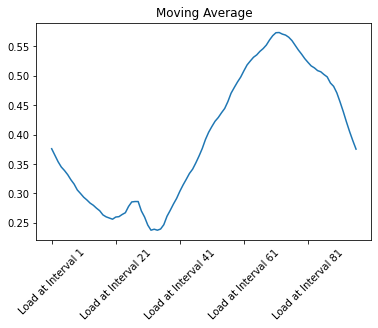

In [ ]:
def moving_average(df, window):
    """
    Calculates the moving average of a given dataframe.
    """
    return df.rolling(window=window).mean()
lp_df = my_load_profiles.copy()
#lp_df = lp_df.T
ma_df = moving_average(lp_df, window=3)

    
#ma_df = ma_df.T
#print(ma_df)
#lp_df['Moving_Avg'] = ma_df
#print(ma_df)
ma_df.iloc[-1].plot(rot=45, title='Moving Average')

# Training, Validation Split

In [ ]:

train_df = my_load_profiles[:int(len(my_load_profiles) * 0.9)]
val_df = my_load_profiles[int(len(my_load_profiles) * 0.9):]
train_df.fillna(0, inplace = True)
val_df.fillna(0, inplace = True)
#print(train_df.isnull().any())
#print(val_df.isnull().any())

def moving_average(df, window):
    """
    Calculates the moving average of a given dataframe.
    """
    return df.rolling(window=window).mean()
vdf = val_df.copy()
#lp_df = lp_df.T
vdma_df = moving_average(vdf, window=3)
#ma_df = ma_df.T
#print(ma_df)
#lp_df['Moving_Avg'] = ma_df



/home/austin/Desktop/Repositories/dae/LFv/lib/python3.9/site-packages/pandas/core/frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [ ]:
nn = tf.keras.Sequential([
    tf.keras.layers.Dense(96, input_shape=(96,), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(96, activation='relu'),
])
nn.compile(optimizer='adam', loss='mean_absolute_error')
target_df = train_df.shift(1, axis = 0)
target_df.fillna(0, inplace=True)
#print(target_df)
nn.fit(train_df, target_df, epochs=10)
nn_predictions = nn.predict(val_df)
#nn_predictions = pd.DataFrame(nn_predictions)
#print(nn_predictions)

print(nn.summary())

2021-08-02 13:14:55.567608: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-02 13:14:55.601383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-02 13:14:55.601817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.74GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-02 13:14:55.601873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-02 13:14:55.601915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library '

        Load at Interval 1  Load at Interval 2  Load at Interval 3  \
0                    0.000               0.000               0.000   
1                   11.489              11.413              11.364   
2                   11.668              11.589              11.538   
3                   11.457              11.381              11.332   
4                   11.358              11.280              11.228   
...                    ...                 ...                 ...   
448403              11.020              10.875              10.732   
448404              10.542              10.414              10.298   
448405              10.169              10.040               9.917   
448406              10.901              10.744              10.577   
448407              10.960              10.808              10.650   

        Load at Interval 4  Load at Interval 5  Load at Interval 6  \
0                    0.000               0.000               0.000   
1                  

2021-08-02 13:14:56.107471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-02 13:14:56.109302: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3593360000 Hz


Epoch 1/10
14013/14013 [==============================] - 8s 564us/step - loss: 5.6717
Epoch 2/10
14013/14013 [==============================] - 8s 558us/step - loss: 5.2563
Epoch 3/10
14013/14013 [==============================] - 8s 578us/step - loss: 5.1560
Epoch 4/10
14013/14013 [==============================] - 8s 577us/step - loss: 5.3494
Epoch 5/10
14013/14013 [==============================] - 8s 556us/step - loss: 5.1975
Epoch 6/10
14013/14013 [==============================] - 8s 551us/step - loss: 5.1802
Epoch 7/10
14013/14013 [==============================] - 8s 548us/step - loss: 5.3288
Epoch 8/10
14013/14013 [==============================] - 8s 545us/step - loss: 5.2579
Epoch 9/10
14013/14013 [==============================] - 8s 543us/step - loss: 5.5247
Epoch 10/10
14013/14013 [==============================] - 8s 545us/step - loss: 5.6203
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape  

# Akaike Information Criterion (AIC), out-of-sample error estimate, lower AIC values indicate higher fidelity for out of sample predictions.

0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
                       ..
Load at Interval 92   NaN
Load at Interval 93   NaN
Load at Interval 94   NaN
Load at Interval 95   NaN
Load at Interval 96   NaN
Length: 192, dtype: float64
Load at Interval 1     46.939683
Load at Interval 2     46.498948
Load at Interval 3     46.065841
Load at Interval 4     45.641024
Load at Interval 5     45.236579
                         ...    
Load at Interval 92    50.972202
Load at Interval 93    77.864314
Load at Interval 94    76.660891
Load at Interval 95    75.504936
Load at Interval 96    74.394733
Length: 96, dtype: float64
NEURAL NETWORK AIC
0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
                       ..
Load at Interval 92   NaN
Load at Interval 93   NaN
Load at Interval 94   NaN
Load at Interval 95   NaN
Load at Interval 

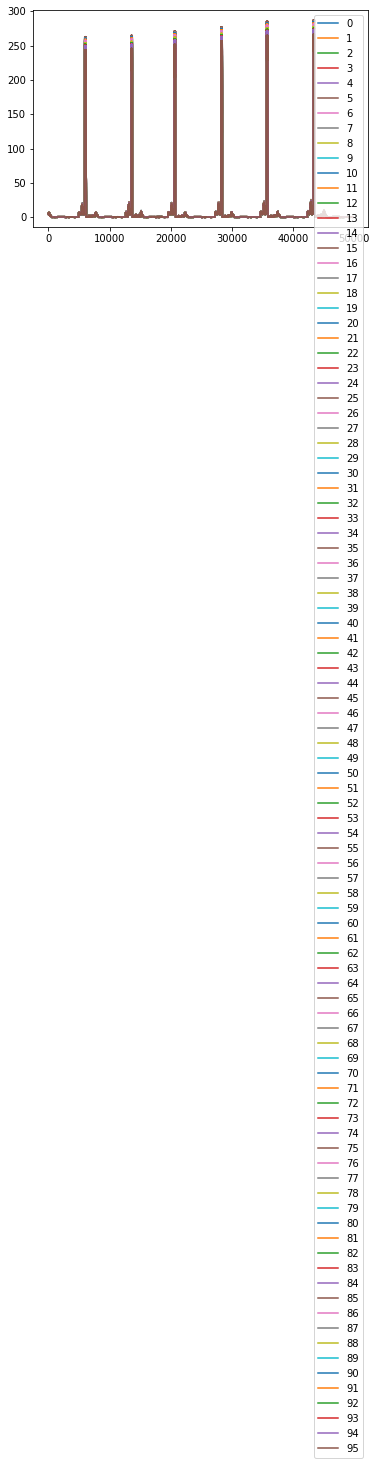

In [ ]:
#print(nn_predictions)
#print(val_df)
nn_predictions = pd.DataFrame(nn_predictions)
#nn_predictions.plot()
nn_mse =  np.mean((nn_predictions - val_df)**2)
moving_average_mse = ((vdma_df-vdf)**2).mean()
print(nn_mse)
print(moving_average_mse)
def aic(mse, k):
    return 2 * k - 2 * mse
aic_nn_mse = aic(nn_mse, k=19058)
aic_vdma_mse = aic(moving_average_mse, k=3)

print("NEURAL NETWORK AIC")
print(aic_nn_mse)
print("MOVING AVERAGE AIC")
print(aic_vdma_mse)
